# ENGAGEMENT SCORE PREDICTION


In [33]:
#Imports
import tensorflow as tf
import sklearn
from tensorflow import keras
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.api.types import is_numeric_dtype

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.base import clone

#### Reading Files

In [ ]:
train=pd.read_excel('train.xlsx')

In [ ]:
test=pd.read_excel('test.xlsx')

In [ ]:
sample_submission=pd.read_excel('sample_submission.xlsx')

####View data

In [ ]:
train.head()

,row_id,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score
0,1,19990,37,128,24,Male,Student,180,1000,4.33
1,2,5304,32,132,14,Female,Student,330,714,1.79
2,3,1840,12,24,19,Male,Student,180,138,4.35
3,4,12597,23,112,19,Male,Student,220,613,3.77
4,5,13626,23,112,27,Male,Working Professional,220,613,3.13


In [ ]:
train.describe()

,row_id,user_id,category_id,video_id,age,followers,views,engagement_score
count,89197.000000,89197.000000,89197.000000,89197.000000,89197.000000,89197.000000,89197.000000,89197.000000
mean,44599.000000,13881.909806,18.323733,77.715383,24.848616,252.460172,502.980268,3.487797
std,25749.100318,8005.582771,11.675154,48.469656,8.955535,46.094468,268.569482,0.863498
min,1.000000,1.000000,1.000000,1.000000,10.000000,160.000000,30.000000,0.000000
25%,22300.000000,6945.000000,8.000000,34.000000,18.000000,230.000000,229.000000,2.900000
50%,44599.000000,13892.000000,16.000000,76.000000,23.000000,240.000000,467.000000,3.710000
75%,66898.000000,20819.000000,26.000000,120.000000,32.000000,280.000000,714.000000,4.150000
max,89197.000000,27734.000000,47.000000,175.000000,68.000000,360.000000,1000.000000,5.000000


#### Split Features into categorical and numeric lists

In [ ]:
numcollist= [ 'followers', 'views', 'age']

In [ ]:
catcollist=['user_id', 'video_id','gender', 'profession', 'category_id']

## EDA


#### Distribution of target variable

In [ ]:
#Function to generate histogram of target variable
def target_distriution(target, df):
  
  #Distribution plot of Target variable  
  plt.figure(figsize=(14,6))
  
  sns.histplot(df[target], kde = True, bins=50)
  plt.axvline(df[target].mean(), color='lightgreen', linewidth=3, label='Mean')
  plt.axvline(np.percentile(df[target],25), color='brown', linewidth=3, label='Quartiles')
  plt.axvline(np.percentile(df[target],75), color='brown', linewidth=3)
  plt.xlabel(target,fontsize=14)
  plt.ylabel('Frequency',fontsize=14)
  plt.title('Histogram of ' + target,fontsize=14)
  plt.legend(fontsize=14)



In [ ]:
#Function to generate histogram of numeric features alogside the boxplot
def feature_distribution(numcollist, df):
  for col in numcollist:
    plt.figure(figsize=(14,6))
    plt.subplot(2,1,1)
    sns.histplot(data=df[col], kde = True, bins=50)
    plt.title('Distribution of ' + col,fontsize=14)
    plt.subplot(2,1,2)
    sns.boxplot(x=col, data=df)
    plt.show


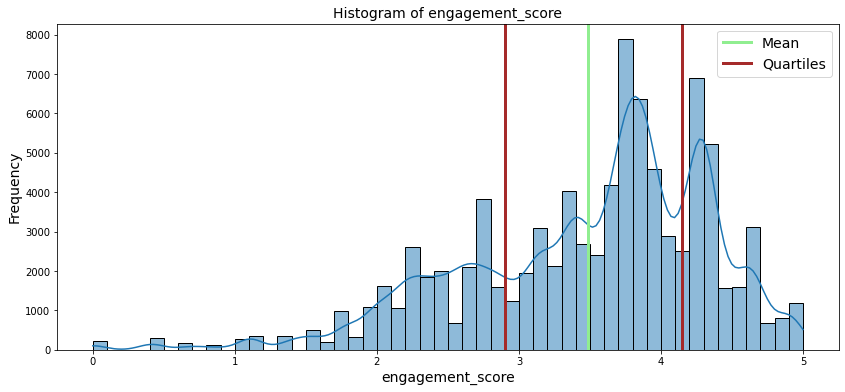

In [ ]:
target='engagement_score'
df=train
target_distriution(target, df)

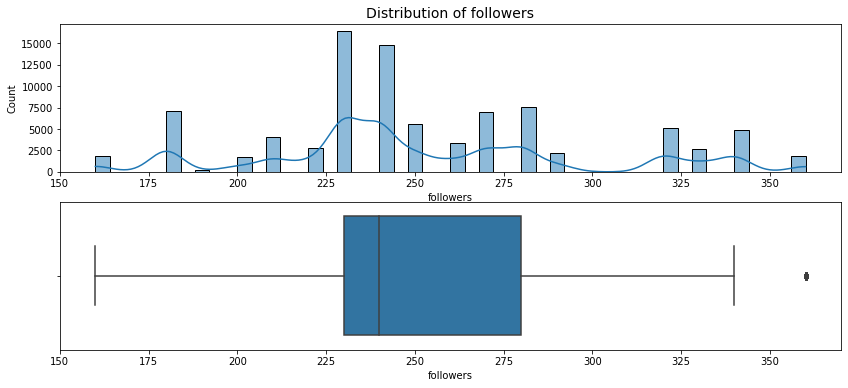

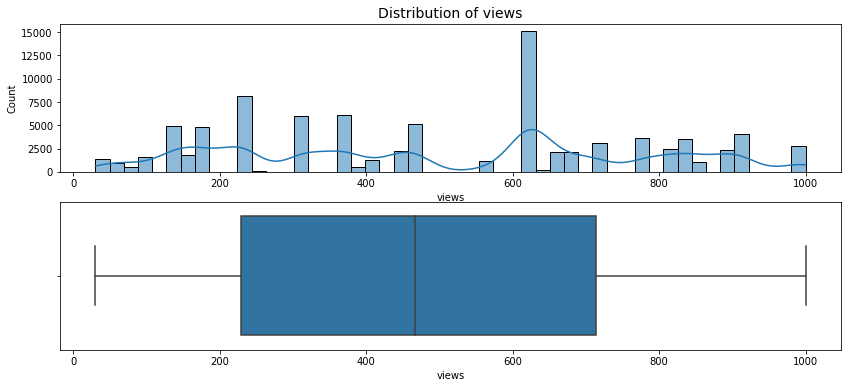

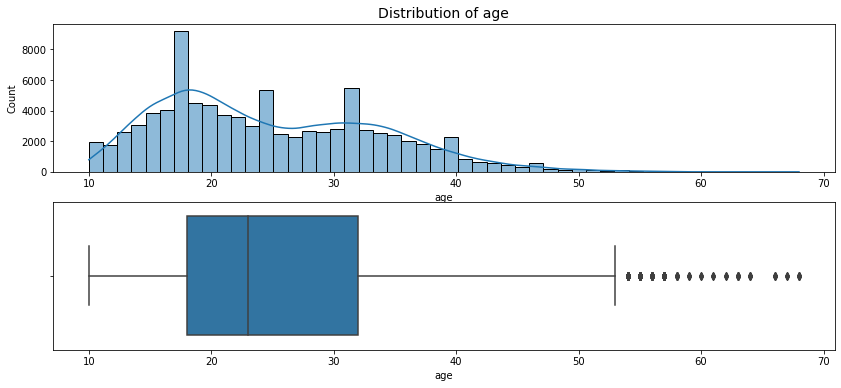

In [ ]:
feature_distribution(numcollist, df)

### Observations:
1. The distribution of target variable is not normal and left-skewed.
2. Feature variable, followers has outlier values above 350.
3. Age also has outliers.

#### Calculating upper extremes

In [ ]:
stats=train.describe()

In [ ]:
stats.loc['75%', 'followers']+ (1.5*(stats.loc['75%', 'followers']-stats.loc['25%', 'followers']))

355.0

In [ ]:
stats.loc['75%', 'age']+ (1.5*(stats.loc['75%', 'age']-stats.loc['25%', 'age']))

53.0

#### Correlation of numeric features with target variable.

In [ ]:
def feature_correlation(numcollist, target, df):
  for col in numcollist:
    correlation= df[target].corr(df[col])
    plt.figure(figsize=(14,6))
    plt.scatter(x=col, y=target, data=df)
    plt.title('Scatter plot of {} with {} ({})'.format(col, target, round(correlation, 2))  ,fontsize=14)

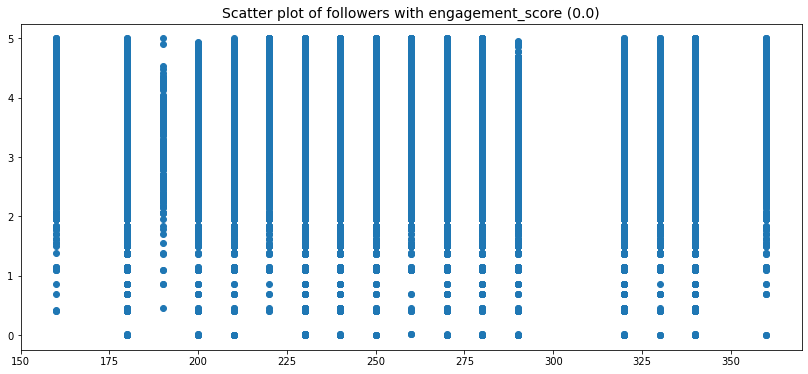

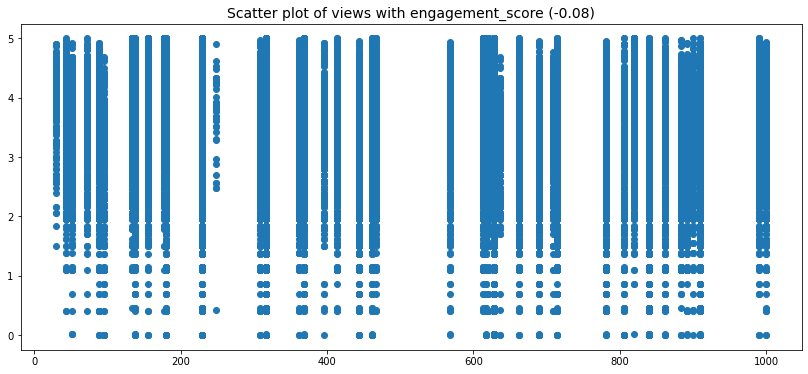

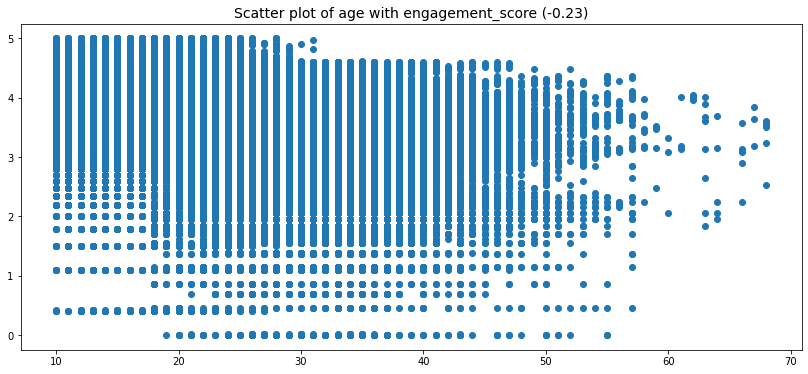

In [ ]:
feature_correlation(numcollist, target, df)

As seen above, there is some correlation of 'age' with 'engagement_score'

#### Understanding categorical features

In [ ]:
def view_categorical(categorical):
  for col in categorical:
    
    plt.figure(figsize=(14,10))
    plt.subplot(2,1,1)
    df[col].value_counts().plot(kind='bar')
    plt.title('Count of categories in {} '.format(col  ,fontsize=14))
    plt.subplot(2,1,2)
    sns.boxplot(x=col, y=target, data=df)
    plt.title('{} vs {} '.format(col, target  ,fontsize=14))
    

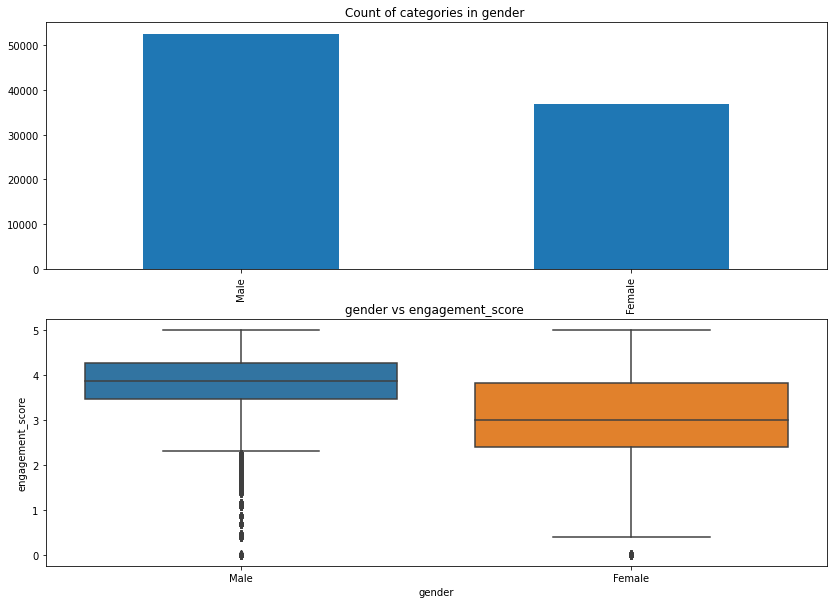

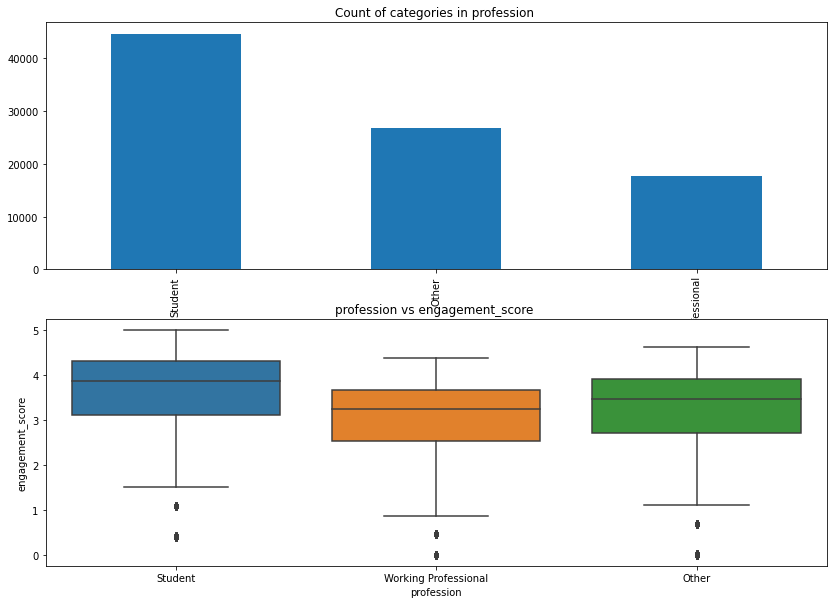

In [ ]:
categorical=['gender', 'profession']
view_categorical(categorical)

#### Observations:
1. The count of Male an Student categories is the highest in 'gender' and 'profession' variabls, respectively.
2. Outlier are also present in the categories- Male, Student, Professional and Other.

#### Identifying outliers:
The following points are outliers. However, since the Random Forest model is finally used, these outliers are not removed from the data. Random Forests are robust with outliers.

In [ ]:
idx1=train[train['followers']>350].index.to_list()
idx2=train[(train['profession']=='Student') & (train['engagement_score']<1.4)].index.to_list()
idx3=train[(train['profession']=='Working Professional') & (train['engagement_score']<.7)].index.to_list()
idx4=train[(train['profession']=='Other') & (train['engagement_score']<1.2)].index.to_list()
idx5=train[(train['gender']=='Male') & (train['engagement_score']<2)].index.to_list()
idx6=train[(train['age']>53) ].index.to_list()
idx7=train[(train['gender']=='Female') & (train['engagement_score']<.2)].index.to_list()
indices=set(idx1+idx2+idx3+idx4+idx5+idx6+idx7)
#train=train.drop(indices, axis=0)

##Train test split
Since there are several categories, after inclusion of user_id, video_id and category_id, the splitting of data may exclude certain categories alltogether. The following function ensures that the unique categories are represented. However, it does not guarantee a good enough representation of the category for training.But it does save the hassels of categories getting completely ignored.

In [ ]:
def train_testsplit(train, dropcols, target):
  """To split train to X_train, X_test and X_valid and correspong y, with X_train containing all categories"""

  for col in catcollist:
    train[col]=train[col].fillna('Absent')
  idx_list=[]
  for col in catcollist:
    for cat in train[col].value_counts().index:
      idx=train[train[col]==cat].index[0]
      idx_list.append(idx)
  unique_cat_df=train.loc[idx_list]

  train, test= train_test_split(train, test_size=0.10, random_state=42)
  #train,valid=train_test_split(train, test_size=0.10, random_state=42)

  train=pd.concat([train, unique_cat_df], axis=0)
  train=train.drop_duplicates()

  X_train=train.drop(dropcols, axis=1)
  X_test=test.drop(dropcols, axis=1)
  #X_valid=valid.drop(['Id', 'SalePrice'], axis=1)
  y_train=train[target].values
  y_test= test[target].values
  #y_valid=valid['SalePrice'].values

  return X_train, X_test,  y_train, y_test

# call the function
dropcols=['row_id', 'engagement_score']

target='engagement_score'
X_train, X_test,  y_train, y_test = train_testsplit(train, dropcols, target)

## Pre-processing pipeline
This pipeline takes care of all the preprocessing for both the numeric and categorical features. The preprocessing part covers missing imputation(Thankfully, there are no nan values in this data), scaling, and categorical encoding. It then takes into account the final estimator to train the data.


In [ ]:
def fit_pipeline(numcollist, catcollist, X_train, y_train, final_estimator):
    """This function creates a pre-processing pipeline and fits the data using the final estimator.
    Arguments:
    numcollist-- list of numerical features
    catcollist-- list of categorical features
    final_estimator-- tuple of algo name and algo
    Returns:
    fitted model"""
    
    # assigning the previously craeted feature lists and data
    numcollist=numcollist
    catcollist=catcollist
           
    # Define preprocessing for numeric columns (scale them)
    num_pipeline=Pipeline([('imputer', SimpleImputer(missing_values= np.nan or None,strategy = 'mean')),('scaler', StandardScaler())])
    
    # Define preprocessing for categorical features (encode them)
    cat_pipeline=Pipeline([('imputer', SimpleImputer(missing_values= np.nan or None,strategy = 'constant',fill_value='absent')),('ohc', OneHotEncoder(handle_unknown='ignore'))])

    # Combine preprocessing steps
    preprocessor=ColumnTransformer(transformers=[('num', num_pipeline,numcollist), ('cat', cat_pipeline, catcollist)])
        
    # Create preprocessing and training pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', final_estimator)])
    
    model= pipeline.fit(X_train, y_train)
    
    return model


## Evaluating models.
Here we have 2 functions: 
1. View_predictions- This function is use to view the model performance on test data.
2. Evaluate_model- This function displays metrics on model performance on tran set and test set.

In [ ]:
def view_predictions(model):
  """This function creates a scatter plot of the predictions on the test data and shows the test performance, for validation purpose """  
    
  predictions = model.predict(X_test)

  # Display metrics
  print('Test set performance:')
  mse = round(mean_squared_error(y_test, predictions),2)
  print("MSE:", mse)
  rmse = round(np.sqrt(mse),2)
  print("RMSE:", rmse)
  r2 = round(r2_score(y_test, predictions),2)
  print("R2:", r2)

  # Plot predicted vs actual
  plt.scatter(y_test, predictions)
  plt.xlabel('Actual Labels')
  plt.ylabel('Predicted Labels')
  plt.title('Predictions of ' + target)
     
  plt.plot(y_test,y_test, color='magenta')
  plt.show()
    

In [ ]:
def evaluate_model(model):
  """This function evaluates the model on train and test with different metrics"""
  train_pred=model.predict(X_train)
  test_pred=model.predict(X_test)
  print('Root mean sqaured error on train set is {}'.format(round(np.sqrt(mean_squared_error(y_train, train_pred)),2)))
  print('Root mean sqaured error on test set is {}'.format(round(np.sqrt(mean_squared_error(y_test, test_pred)),2)))
  print('R2 score on train set is {}'.format(np.round_(r2_score(y_train, train_pred),2)))
  print('R2 score on test set is {}'.format(np.round_(r2_score(y_test, test_pred), 2)))
  

## Training with Ridge Regression

In [ ]:
final_estimator=Ridge()
model1=fit_pipeline(numcollist, catcollist,X_train, y_train, final_estimator)

Test set performance:
MSE: 0.35
RMSE: 0.59
R2: 0.54


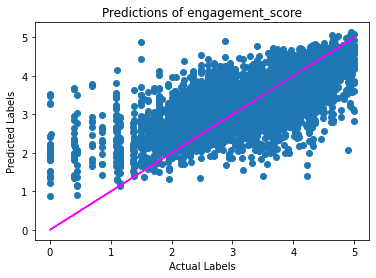

In [ ]:
view_predictions(model1)

In [ ]:
evaluate_model(model1)

Root mean sqaured error on train set is 0.49
Root mean sqaured error on test set is 0.59
R2 score on train set is 0.68
R2 score on test set is 0.54


## Training with Random forest

In [ ]:
final_estimator=RandomForestRegressor()
model2=fit_pipeline(numcollist, catcollist,X_train, y_train, final_estimator)


Test set performance:
MSE: 0.29
RMSE: 0.54
R2: 0.61


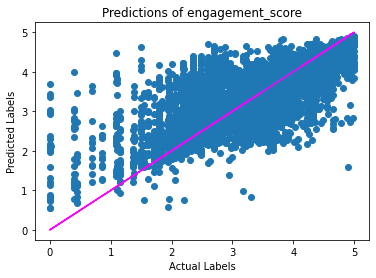

In [ ]:
view_predictions(model2)

In [ ]:
evaluate_model(model2)

Root mean sqaured error on train set is 0.24
Root mean sqaured error on test set is 0.54
R2 score on train set is 0.93
R2 score on test set is 0.61


## Generate predictions

In [37]:
test_set_pred= np.round_(model1.predict(test),2)

In [38]:
test_set_pred

array([4.23, 3.56, 2.37, ..., 3.24, 3.75, 3.26])

In [39]:
sample_submission['engagement_score']=test_set_pred

In [40]:
sample_submission.to_csv('sample_submission.csv')

In [43]:
test_set_pred2= np.round_(model2.predict(test),2)

In [44]:
sample_submission['engagement_score']=test_set_pred2

In [45]:
sample_submission.to_csv('sample_submission2.csv')